In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
!pip install pandas torch transformers umap-learn hdbscan scikit-learn matplotlib seaborn nltk

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import umap
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

# Download NLTK Disabled Words
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

# Pre-process
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

df = pd.read_csv('abcnews-date-text.csv', nrows=50000)
df = df.rename(columns={'headline_text': 'text'})
df['text'] = df['text'].apply(preprocess_text)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading BERT Models and Markers
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Get text embedding
def get_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings.extend(outputs.last_hidden_state[:, 0, :].cpu().numpy())
    return embeddings

# Get Embedded
embeddings = get_embeddings_batch(df['text'].tolist())

# Dimensionality Reduction
umap_model = umap.UMAP(n_neighbors=15, n_components=10, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

# KMeans
n_topics = 10
kmeans = KMeans(n_clusters=n_topics, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embeddings)

# DataFrame Add Clustering labels to DataFrame
df['topic'] = cluster_labels

def extract_keywords(df, cluster_labels, n_clusters):
    keywords = {}
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['text'])

    for topic in range(n_clusters):
        cluster_texts = df[df['topic'] == topic]['text']
        if len(cluster_texts) > 0:
            tfidf_vector = vectorizer.transform(cluster_texts)
            keywords_vector = tfidf_vector.sum(axis=0).A1
            feature_names = vectorizer.get_feature_names_out()
            top_keywords = [feature_names[i] for i in keywords_vector.argsort()[-10:]]
            keywords[topic] = top_keywords
    return keywords

keywords = extract_keywords(df, cluster_labels, n_topics)
for topic, words in keywords.items():
    print(f"Topic {topic}: {words}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Topic 0: ['industry', 'concerns', 'rise', 'rate', 'new', 'study', 'funds', 'health', 'boost', 'farmers']
Topic 1: ['australia', 'tour', 'open', 'wins', 'title', 'england', 'final', 'win', 'world', 'cup']
Topic 2: ['death', 'probe', 'car', 'court', 'charged', 'missing', 'murder', 'crash', 'man', 'police']
Topic 3: ['bush', 'talks', 'says', 'korea', 'troops', 'war', 'baghdad', 'killed', 'iraqi', 'iraq']
Topic 4: ['protest', 'decision', 'trial', 'inquiry', 'says', 'claims', 'war', 'case', 'appeal', 'court']
Topic 5: ['nsw', 'restrictions', 'boost', 'tourism', 'new', 'rain', 'council', 'centre', 'water', 'plan']
Topic 6: ['awards', 'bali', 'birthday', 'memorial', 'honours', 'anzac', 'day', 'wins', 'award', 'festival']
Topic 7: ['local', 'tas', 'govts', 'qld', 'wa', 'sa', 'fed', 'urged', 'vic', 'govt']
Topic 8: ['mayor', 'qld', 'minister', 'plan', 'labor', 'act', 'new', 'mp', 'nsw', 'council']
Topic 9: ['beckham', 'blues', 'return', 'tour', 'takes', 'new', 'howard', 'man', 'set', 'says']


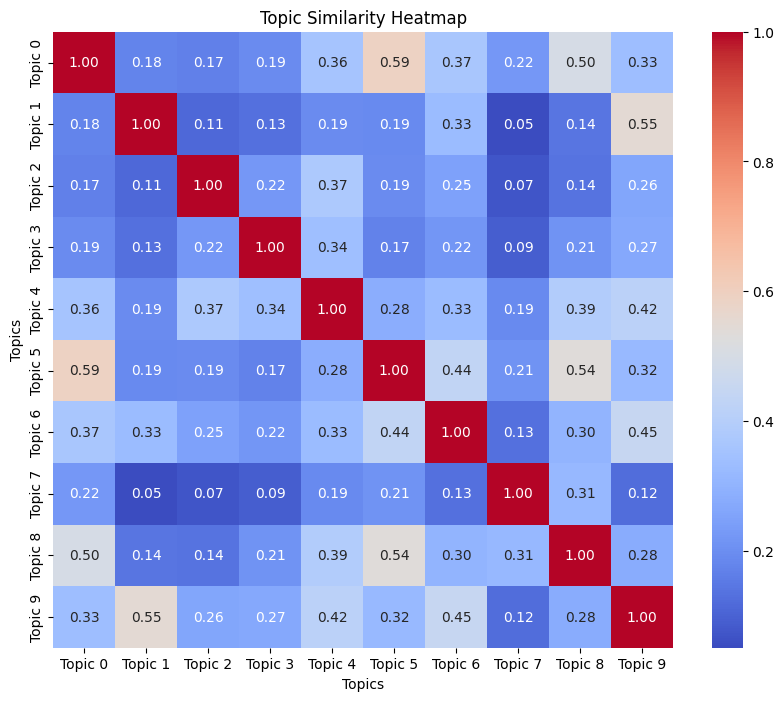

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

def generate_heatmap(df, n_topics):
    # Compute the TF-IDF vector
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(df['text'])

    # Initializing the Theme Centre List
    topic_centroids = []

    for topic in range(n_topics):
        # Get the text of the current topic
        cluster_texts = df[df['topic'] == topic]['text']
        if len(cluster_texts) > 0:
            # Calculate the TF-IDF vector for the current topic
            tfidf_vector = vectorizer.transform(cluster_texts)
            centroid = tfidf_vector.mean(axis=0)
            topic_centroids.append(centroid.A1)  # Converting sparse matrices to one-dimensional arrays
        else:
            topic_centroids.append(np.zeros(tfidf_matrix.shape[1]))  # Handling of topics without text

    # Convert to NumPy array
    topic_centroids = np.array(topic_centroids)

    # Calculate the similarity matrix between topics
    similarity_matrix = 1 - pairwise_distances(topic_centroids, metric='cosine')

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt='.2f',
                xticklabels=[f'Topic {i}' for i in range(n_topics)],
                yticklabels=[f'Topic {i}' for i in range(n_topics)])
    plt.title('Topic Similarity Heatmap')
    plt.xlabel('Topics')
    plt.ylabel('Topics')
    plt.show()

generate_heatmap(df, n_topics)

In [ ]:
import numpy as np
import gensim
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer

# Calculate topic consistency
def calculate_average_topic_coherence(df, n_topics):
    coherence_scores = []
    dictionary = gensim.corpora.Dictionary([text.split() for text in df['text']])

    for topic in range(n_topics):
        cluster_texts = df[df['topic'] == topic]['text']
        if len(cluster_texts) > 0:
            texts = [text.split() for text in cluster_texts]

            tfidf_vectorizer = TfidfVectorizer()
            tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_texts)
            feature_names = tfidf_vectorizer.get_feature_names_out()
            top_keywords_idx = tfidf_matrix.sum(axis=0).A1.argsort()[-10:]
            topic_words = [feature_names[i] for i in top_keywords_idx]
            coherence_model = CoherenceModel(topics=[topic_words], texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            coherence_scores.append(coherence_score)

    return np.mean(coherence_scores) if coherence_scores else 0

# Topic Diversity
def calculate_topic_diversity(df, n_topics):
    unique_words = set()
    total_words_per_topic = []

    for topic in range(n_topics):
        cluster_texts = df[df['topic'] == topic]['text']
        if len(cluster_texts) > 0:
            topic_unique_words = set()
            total_words = 0
            for text in cluster_texts:
                words = text.split()
                topic_unique_words.update(words)
                total_words += len(words)
            unique_words.update(topic_unique_words)
            total_words_per_topic.append(total_words)

    total_words = sum(total_words_per_topic)
    diversity = len(unique_words) / total_words if total_words > 0 else 0
    return diversity

average_topic_coherence = calculate_average_topic_coherence(df, n_topics)
topic_diversity = calculate_topic_diversity(df, n_topics)

print("Average Topic Coherence Score:", average_topic_coherence)
print("Topic Diversity:", topic_diversity)

Average Topic Coherence Score: 0.26007169945564373
Topic Diversity: 0.07897321771161077
